In [9]:
%load_ext rpy2.ipython
%R library(ggplot2);library(dplyr);library(magrittr);library(parody); library(reshape)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

Error in library(parody) : there is no package called ‘parody’


In [10]:
import glob
import os

names=glob.glob("./data/nahant_tRNA_count/*")

phages=[]
count=0

for name in names:
    phages.append(name.split("/")[-1].split("t")[0])
    count+=1
  
print(count)

tRNA_phages=[]

for phage in phages:
    if os.path.getsize("./data/nahant_trna_count/"+phage+"trnas.txt")>0:
        #print("phage "+phage+" has tRNAs")
        tRNA_phages.append(phage)
    #else:
     #   print("phage "+phage+" does not have tRNAs")

print("there are a total of "+str(len(phages))+" phages but only "+str(len(tRNA_phages))+" have tRNAs")

287
there are a total of 287 phages but only 65 have tRNAs


In [11]:
%%R -i tRNA_phages
tRNA_phages

 [1] "1.007.O." "1.012.O." "1.013.O." "1.022.O." "1.023.O." "1.024.O."
 [7] "1.025.O." "1.026.O." "1.031.O." "1.032.O." "1.033.O." "1.046.O."
[13] "1.060.A." "1.076.O." "1.081.O." "1.085.O." "1.088.O." "1.089.O."
[19] "1.098.O." "1.101.O." "1.103.O." "1.110.O." "1.116.O." "1.118.A."
[25] "1.118.B." "1.121.O." "1.122.A." "1.122.B." "1.134.O." "1.150.O."
[31] "1.152.O." "1.160.O." "1.169.O." "1.172.O." "1.176.O." "1.186.O."
[37] "1.187.O." "1.188.A." "1.188.B." "1.188.C." "1.193.O." "1.208.B."
[43] "1.210.O." "1.214.O." "1.224.A." "1.237.A." "1.237.B." "1.240.O."
[49] "1.242.O." "1.243.O." "1.244.A." "1.247.A." "1.247.B." "1.250.O."
[55] "1.251.O." "1.255.O." "1.261.O." "1.262.O." "1.273.O." "1.275.O."
[61] "1.285.O." "1.291.O." "1.293.O." "2.130.O." "2.275.O."


In [12]:
%%R -i tRNA_phages
###Look through tRNA content and select phages with unique tRNA profiles

phagelist<-tRNA_phages
trna_file_path<-"./data/nahant_trna_count/"

codons<-read.table("./data/codon_list.txt", header=FALSE)
colnames(codons)[2]<-"V6"

for (phage in phagelist){
    trna<-read.table(paste(trna_file_path, phage, "trnas.txt",sep=""), skip=3, header=FALSE,sep="\t")
    trna%>%group_by(V6)%>%summarise(count=n())->trna
    colnames(trna)[2]<-phage
    codons<-merge(codons, trna, by="V6", all.x=TRUE, all.y=TRUE)
}


codons$V1<-NULL
codons[is.na(codons)]<-0
rownames(codons)<-codons$V6
codons$V6<-NULL

members<-t(as.matrix(codons))
unique_trnas<-rownames(unique(members))
unique_trna_profiles<-unique(members)
print(nrow(members))
print(nrow(unique(members)))
print(data.frame(rowSums(unique_trna_profiles)))
t(unique_trna_profiles[,which(colSums(unique_trna_profiles)>0)])%>%.[,order(colSums(.))]->trnas2
trnas2%>%melt%>%ggplot(aes(X2, X1))+geom_tile(aes(fill=value), position="identity")->plt
plt<-plt+labs(title="Phage tRNA codon distribution for \ntRNA-containing Nahant Vibriophages", x="phage", y="codon")
plt<-plt+theme(axis.text.x = element_blank())
plot(plt)

[1] 65
[1] 28
         rowSums.unique_trna_profiles.
1.007.O.                             4
1.012.O.                             1
1.013.O.                             2
1.022.O.                             1
1.023.O.                             2
1.024.O.                             1
1.025.O.                             1
1.031.O.                             2
1.032.O.                             1
1.046.O.                             2
1.081.O.                            23
1.085.O.                             2
1.110.O.                             1
1.121.O.                             3
1.122.A.                             2
1.169.O.                             1
1.186.O.                             2
1.187.O.                             2
1.193.O.                             4
1.208.B.                             2
1.214.O.                             1
1.240.O.                             1
1.243.O.                             2
1.244.A.                             3
1.262.O.   

In [13]:
%%R
nrow(trnas2)
rownames(trnas2)->ptrnas

In [6]:
from Bio.SeqUtils import GC

%Rpull ptrnas
tstring=""
for i in ptrnas:
    tstring+=i
    print(GC(i))
GC(tstring.replace("?",""))

0.0
33.3333333333
33.3333333333
33.3333333333
66.6666666667
66.6666666667
33.3333333333
33.3333333333
33.3333333333
33.3333333333
66.6666666667
66.6666666667
66.6666666667
33.3333333333
33.3333333333
66.6666666667
66.6666666667
0.0
33.3333333333
33.3333333333
66.6666666667
66.6666666667
66.6666666667
33.3333333333
0.0
33.3333333333
33.3333333333
0.0


41.97530864197531

In [21]:
out=open("nahant_phage_tRNA_summary.txt","w")
out.write("phage_short\tphage_full\tbound1\tbound2\ttRNA\tanti_codon\tintron_bound1\titron_bound2\tscore\n")

for phage in tRNA_phages:
    info=open("./data/nahant_tRNA_count/"+phage+"trnas.txt").readlines()
    for line in info[3:]:
        vec=line.split("\t")
        
        out.write(phage+"\t"+vec[0]+"\t"+vec[2]+"\t"+vec[3]+"\t"+vec[4]+"\t"+vec[5]+"\t"+vec[6]+"\t"+vec[7]+"\t"+vec[8])
out.close()

In [16]:
Charged="Arginine - Arg - R\tLysine - Lys - K\tAspartic acid - Asp - D\tGlutamic acid - Glu - E"
Polar="Glutamine - Gln - Q\tAsparagine - Asn - N\tHistidine - His - H\tSerine - Ser - S\tThreonine - Thr - T\tTyrosine - Tyr - Y\tCysteine - Cys - C\tMethionine - Met - M\tTryptophan - Trp - W"
Hydrophobic= "Alanine - Ala - A\tIsoleucine - Ile - I\tLeucine - Leu - L\tPhenylalanine - Phe - F\tValine - Val - V\tProline - Pro - P\tGlycine - Gly - G"

categories=""

for c in Charged.split("\t"):
    vec=c.split(" - ")
    name=vec[0]
    abrev=vec[1]
    letter=vec[2]
    categories+=name+"\t"+abrev+"\t"+letter+"\tcharged\n"

for c in Polar.split("\t"):
    vec=c.split(" - ")
    name=vec[0]
    abrev=vec[1]
    letter=vec[2]
    categories+=name+"\t"+abrev+"\t"+letter+"\tpolar\n"  
    
for c in Hydrophobic.split("\t"):
    vec=c.split(" - ")
    name=vec[0]
    abrev=vec[1]
    letter=vec[2]
    categories+=name+"\t"+abrev+"\t"+letter+"\thydrophobic\n" 

In [17]:
%load_ext rpy2.ipython
%R library(dplyr);library(magrittr);library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['magrittr', 'dplyr', 'ggplot2', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [18]:
%%R -i categories
prot_cats<-textConnection(categories)
protinfo<-read.table(prot_cats, sep="\t")
head(protinfo)

             V1  V2 V3      V4
1      Arginine Arg  R charged
2        Lysine Lys  K charged
3 Aspartic acid Asp  D charged
4 Glutamic acid Glu  E charged
5     Glutamine Gln  Q   polar
6    Asparagine Asn  N   polar


In [25]:
%%R -i categories
tRNA_info<-read.table("nahant_phage_tRNA_summary.txt", sep="\t", header=TRUE, fill=TRUE)
tRNA_info%>%group_by(phage_short)%>%summarise(count=n())%>%group_by(count)%>%summarise(number=n())
#tRNA_info%>%group_by(tRNA)%>%summarise(count=n())
tRNA_info%>%group_by(phage_short)%>%summarise(count=n())->trna_count
tRNA_info$phage_total<-trna_count$count[match( tRNA_info$phage_short,trna_count$phage_short)]
tRNA_info$prot_type<-protinfo$V4[match(tRNA_info$tRNA, protinfo$V2)]
head(tRNA_info)
tRNA_info%>%group_by(phage_short)%>%summarise(trna_count=n())%>%write.table("/Users/jmb/Desktop/ViralFate/Annotation/nahant_phage_tRNA_count.txt",quote=FALSE, row.names=FALSE, sep="\t")

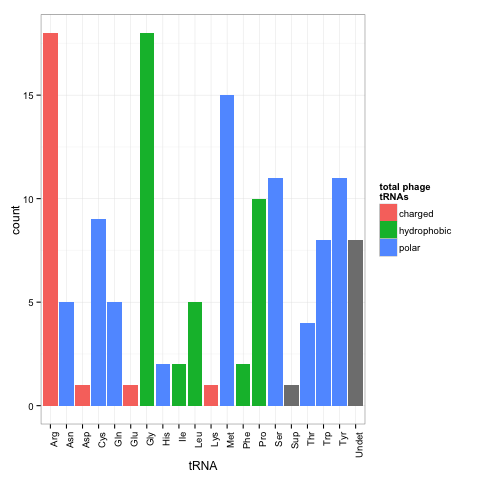

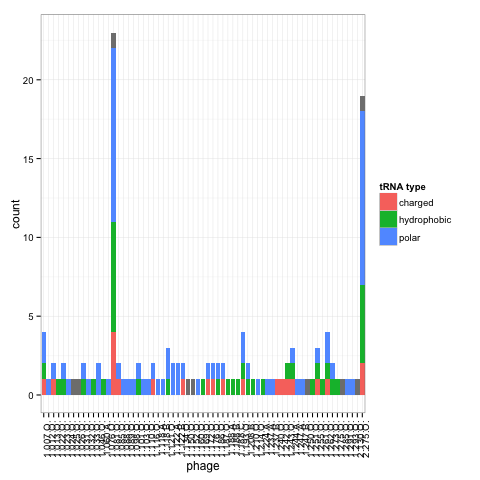

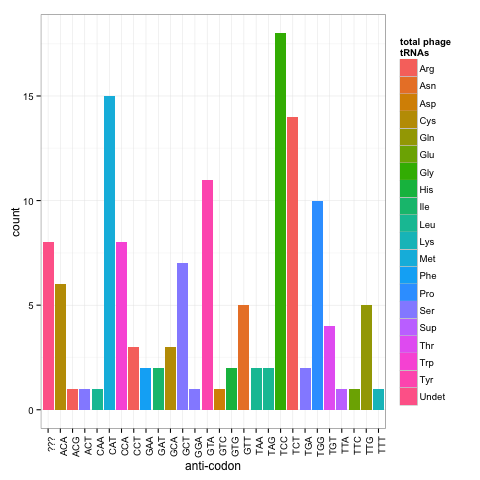

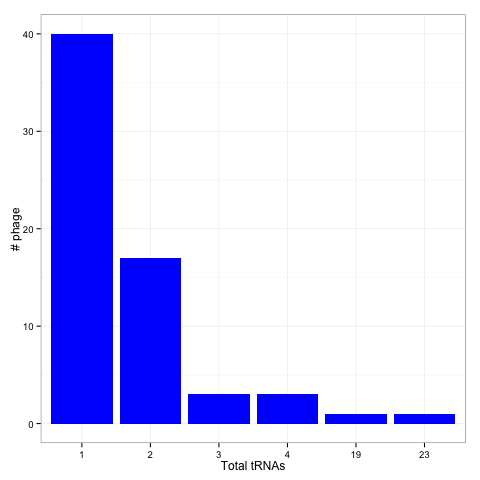

In [24]:
%%R
p<-ggplot(tRNA_info, aes(tRNA, fill=factor(prot_type)))+geom_bar()+theme_bw()
p+theme(axis.text.x = element_text(angle = 90, hjust = 1))+labs(x="tRNA", y="count",fill="total phage\ntRNAs")->p
plot(p)

q<-ggplot(tRNA_info, aes(phage_short, fill=prot_type))+geom_bar()+theme_bw()
q+theme(axis.text.x = element_text(angle = 90, hjust = 1))+labs(x="phage", y="count",fill="tRNA type")->q
plot(q)

r<-ggplot(tRNA_info, aes(anti_codon, fill=factor(tRNA)))+geom_bar()+theme_bw()
r+theme(axis.text.x = element_text(angle = 90, hjust = 1))+labs(x="anti-codon", y="count", fill="total phage\ntRNAs")->r
plot(r)


s<-ggplot(trna_count, aes(factor(count)))+geom_bar(fill="blue")+theme_bw()+labs(x="Total tRNAs", y="# phage")

plot(s)



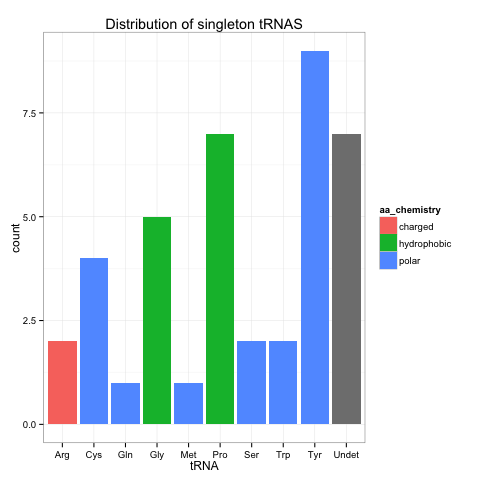

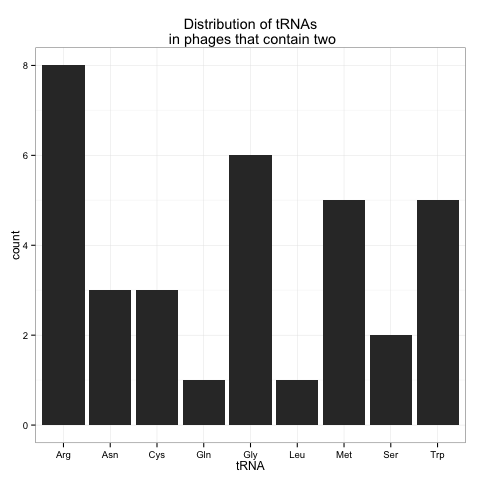

In [25]:
%%R
p<-ggplot(tRNA_info[which(tRNA_info$phage_total==1),],aes(tRNA, fill=prot_type))+geom_bar()+theme_bw()+labs(title="Distribution of singleton tRNAS", fill="aa_chemistry")
q<-ggplot(tRNA_info[which(tRNA_info$phage_total==2),],aes(tRNA))+geom_bar()+theme_bw()+labs(title="Distribution of tRNAs\n in phages that contain two")
plot(p)
plot(q)

In [26]:
%%R -i tRNA_phages
network<-read.table("/Users/jmb/Desktop/ViralFate/OldFolders/Phage-Host/NetworkAdjacencyList.txt",header=TRUE, sep="\t")

network[network$Phage.ID %in% tRNA_phages,]%>%group_by(HRX.HOST.ID)%>%summarise->tRNA_hosts
trna_hosts<-as.vector(tRNA_hosts$HRX.HOST.ID)

In [68]:
%%R
tRNA_info<-read.table("nahant_phage_tRNA_summary.txt", sep="\t", header=TRUE, fill=TRUE)
start<-trna_hosts[1]

network[network$Phage.ID %in% tRNA_phages,]%>%.[.$HRX.HOST.ID==start,]->phage_ts

tRNA_info[tRNA_info$phage_short %in% phage_ts$Phage.ID,]

#that's it for the night.  The host I chose is infected by phages with "undetermined tRNAs."  It's a sign

    phage_short                          phage_full bound1 bound2  tRNA
12     1.025.O. Vibriophage_1.025.O._10N.222.46.B6   64793  64716 Undet
13     1.026.O. Vibriophage_1.026.O._10N.222.49.C7   65304  65227 Undet
67     1.150.O. Vibriophage_1.150.O._10N.222.46.A6   64735  64658 Undet
68     1.152.O. Vibriophage_1.152.O._10N.222.46.E1   64870  64793 Undet
118    2.130.O. Vibriophage_2.130.O._10N.222.46.C2   64873  64796 Undet
    anti_codon intron_bound1 itron_bound2 score
12         ???             0            0 45.05
13         ???             0            0 45.05
67         ???             0            0 45.05
68         ???             0            0 45.05
118        ???             0            0 45.05


In [59]:
%%R
hosttrnas=read.table("10N.222.45.E8.trnas.txt", skip=3)
head(hosttrnas)
hosttrnas%>%group_by(V6)%>%summarise(count=n())->acodon_summary

head(hosttrnas)
head(phage_ts[-1,])
#ggplot(hosttrnas, aes(V6))+geom_bar()+theme(axis.text.x = element_text(angle = 90, hjust = 1))

  Phage.ID   HRX.HOST.ID
2 1.025.O. 10N.222.45.C6
3 2.130.O. 10N.222.45.C6
4 1.152.O. 10N.222.45.C6
5 1.026.O. 10N.222.45.C6


10N.222.45.E8_v062015_contigs_prod.gbk  tRNA_count/
nahant_phage_tRNA_summary.txt           tRNA_numbers.ipynb
